### Exercise1
#### 1.a

In [26]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

In [27]:
#A function to create the S curve
def makeSCurve():
    n_points = 1000
    noise = 0.2
    X, color = datasets.make_s_curve(n_points, noise=noise, random_state=0)
    Y = np.array([X[:,0], X[:,2]])
    Y = Y.T
    # Stretch in all directions
    Y = Y * 2
    # Now add some background noise
    xMin = np.min(Y[:,0])
    xMax = np.max(Y[:,0])
    yMin = np.min(Y[:,1])
    yMax = np.max(Y[:,1])
    
    n_bg = n_points//10
    Ybg = np.zeros(shape=(n_bg,2))
    Ybg[:,0] = np.random.uniform(low=xMin, high=xMax, size=n_bg)
    Ybg[:,1] = np.random.uniform(low=yMin, high=yMax, size=n_bg)
    
    Y = np.concatenate((Y, Ybg))
    return Y

In [28]:
def plotDataAndSOM(data, buttons, fileName):
    fig = plt.figure(figsize=(8, 8))
    # Plot the data in grey
    plt.scatter(data[:,0], data[:,1], c='grey')
    # Plot the buttons in large red dots
    plt.plot(buttons[:,0], buttons[:,1], 'ro', markersize=10)
    # Label axes and figure
    plt.title('S curve dataset, with buttons in red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(fileName)
    

In [29]:
# Create a grid of points, dim p x q, and save grid in a (p*q, 2) array
#   first column: x-coordinate
#   second column: y-coordinate

def createGrid(p, q):
    index = 0
    grid = np.zeros(shape=(p*q, 2))
    for i in range(p):
        for j in range(q):
            index = i*q + j
            grid[index, 0] = i
            grid[index, 1] = j
    return grid

In [30]:
"""
A function to plot the crabs results
It applies a SOM previously computed (parameters grid and buttons) to a given
dataset (parameters data)

Parameters
 X : is the original data that was used to compute the SOM.
     Rows are samples and columns are features.
 idInfo : contains the information (sp and sex for the crab dataset) about
          each data point in X.
          The rows in idInfo match one-to-one to rows in X.
 grid, buttons : obtained from computing the SOM on X.
 fileName : full path to the output file (figure) saved as .pdf or .png
"""
def plotSOMCrabs(x, idInfo, grid, buttons, fileName):
    # Use the following colors for samples of each pair [species, sex]
    # Blue male:     dark blue #0038ff
    # Blue female:   cyan      #00eefd
    # Orange male:   orange    #ffa22f
    # Orange female: yellow    #e9e824
    d = x.shape[0]
    proj = np.zeros(shape=(d, 2))
    zeta = 0.05
    for i in range(d):
        # Find index of nearest button in FEATURE space
        idx = findNearestButtonIndex(x[i], buttons)

        # Assign a label in GRID space, with some noise
        proj[i, 0] = grid[idx, 0] + np.random.normal(0, zeta, 1)
        proj[i, 1] = grid[idx, 1] + np.random.normal(0, zeta, 1)

    # Create the plot
    fig = plt.figure(figsize=(12, 15))

    # Initialize the array that will contain the color assigned to each sample
    # Note: Cannot assume a specific ordering of the input file
    sample_color = np.array(['#AAAAAA'] * d)

    # Define colors and legend for key in plot
    class_color = ['#0038ff', '#00eefd', '#ffa22f', '#e9e824']
    class_label = ['Blue male', 'Blue female', 'Orange male', 'Orange female']

    # Set a pairing of sp and sex
    lst_pairs = [['B', 'M'], ['B', 'F'], ['O', 'M'], ['O', 'F']]

	# Iterate through all samples and set their color
    for i, pair in enumerate(lst_pairs):
        # Get the index to the data points with [sp, sex] == current pair
        idx = np.where((idInfo['sp'] == pair[0]) & (idInfo['sex'] == pair[1]))
        sample_color[idx] = class_color[i]

    # Plot
    plt.scatter(grid[:, 0], grid[:, 1], s=2000, facecolors='none')
    plt.scatter(proj[:, 0], proj[:, 1], s=50, c=sample_color)
    plt.title('Self-organizing map of crabs data', fontsize=16)

    # Add key legend
    recs = []
    for color in class_color:
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=color))

    plt.legend(recs, class_label, loc='lower center', bbox_to_anchor=(1, 0.5))
    plt.savefig(fileName)

In [31]:
# Function for computing distance in grid space.
# Use Euclidean distance.

def getGridDist(z0, z1):
    return np.sqrt(np.sum((z0-z1)**2))

In [32]:
# Function for computing distance in feature space.
# Use Euclidean distance.

def getFeatureDist(z0, z1):
    return np.sqrt(np.sum((z0-z1)**2))

In [33]:
# Create distance matrix between points numbered 1,2,...,K=p*q from grid

def createGridDistMatrix(grid):
    gdm=np.zeros((grid.shape[0],grid.shape[0]))
    for i,gp in enumerate(grid):
        j=i+1
        while j<grid.shape[0]:
            gdm[i,j]=getGridDist(gp,grid[j])
            gdm[j,i]=gdm[i,j]
            j+=1
    return gdm

In [34]:
# Create array for epsilon. Values in the array decrease to 1.

def createEpsilonArray(epsilon_max, N):
    rng= np.random.default_rng(12345)
    eps= rng.integers(0,epsilon_max,N, endpoint=True)
    return np.sort(eps)[::-1]

In [35]:
# Create array for alpha. Values in the array decrease from 
# alpha_max according to the equation in the homework sheet.

def createAlphaArray(alpha_max, lambda_, N):
    t=np.linspace(1,N-1,N)
    alpha= alpha_max-alpha_max*lambda_*t+.5*alpha_max*lambda_**2*t**2
    return alpha

In [36]:
# X is whole data set, K is number of buttons to choose

def initButtons(X, K):
    buttons=np.zeros((K, X.shape[1]))
    for i in range(K):
        for j, x in enumerate(X.T):
            buttons[i,j]= np.random.choice(x)
    return buttons 

In [37]:
# x is one data point, buttons is the grid in FEATURE SPACE

def findNearestButtonIndex(x, buttons):
    dmin=getFeatureDist(x, buttons[0])
    idx=0
    for i,b in enumerate(buttons):
        dm= getFeatureDist(x, b)
        if dm<dmin:
            idx= i
            dmin= dm
    return idx

In [38]:
# Find all buttons within a neighborhood of epsilon of index IN GRID SPACE 
# (return a boolean vector)

def findButtonsInNhd(index, epsilon, buttons):
    bNhd= np.array([getFeatureDist(buttons[index], b) for b in buttons])<epsilon 
    return bNhd

In [39]:
# Do gradient descent step, update each button position IN FEATURE SPACE

def updateButtonPosition(button, x, alpha):
        return button-alpha*(x-button)

In [40]:
# Compute the squared distance between data points and their nearest button

def computeError(data, buttons):
    se= [np.sum((data-b)**2) for b in buttons]
    return np.sum(np.array(se))

In [41]:
# Implementation of the self-organizing map (SOM)

# Parameters
#  X : data, rows are samples and columns are features
#  p, q : dimensions of the grid
#  N : number of iterations
#  alpha_max : upper limit for learning rate
#  epsilon_max : upper limit for radius
#  compute_error : boolean flag to determine if the error is computed.
#                  The computation of the error is time-consuming and may
#                  not be necessary every time the function is called.
#  lambda_ : decay constant for learning rate
                 
# Returns
#  buttons, grid : the buttons and grid of the newly created SOM
#  error : a vector with error values. This vector will contain zeros if 
#          compute_error is False

# TODO: Complete the missing parts in this function following the pseudocode
#       in the homework sheet

def SOM(X, p, q, N, alpha_max, epsilon_max, compute_error=True, lambda_=0.01):
    # 1. Create grid and compute pairwise distances
    grid = createGrid(p, q)
    gridDistMatrix = createGridDistMatrix(grid)
    
    # 2. Randomly select K out of d data points as initial positions
    #    of the buttons
    K = p * q
    d = X.shape[1]
    buttons = initButtons(X, K)
    
    # 3. Create a vector of size N for learning rate alpha
    alpha= createAlphaArray(alpha_max, lambda_, N)
    
    # 4. Create a vector of size N for epsilon 
    epsilon= createEpsilonArray(epsilon_max, N)
    
    # Initialize a vector with N zeros for the error
    # This vector may be returned empty if compute_error is False
    error = np.zeros(N)

    # 5. Iterate N times
    for i in range(N):
        # 6. Initialize/update alpha and epsilon
        alp= alpha[i]
        eps= epsilon[i]
        
        # 7. Choose a random index t in {1, 2, ..., d}
        t= np.random.choice([k for k in range(d)])
        
        # 8. Find button m_star that is nearest to x_t in F
        xt= X[t,:]
        mstar = findNearestButtonIndex(xt, buttons)
        
        # 9. Find all grid points in epsilon-nhd of m_star in GRID SPACE
        b_nhd= findButtonsInNhd(mstar, eps, buttons)
        buttons_nhd=buttons[b_nhd]

        # 10. Update position (in FEATURE SPACE) of all buttons m_j
        #     in epsilon-nhd of m_star, including m_star
        for j,b in enumerate(buttons_nhd):
            buttons_nhd[j]= updateButtonPosition(b, xt, alp)

        # Compute the error 
        # Note: The computation takes place only if compute_error is True
        #       Replace the statement below with your code
        error[i]= computeError(xt, buttons_nhd)

    # 11. Return buttons, grid and error
    return (buttons, grid, error)

#### 1.b

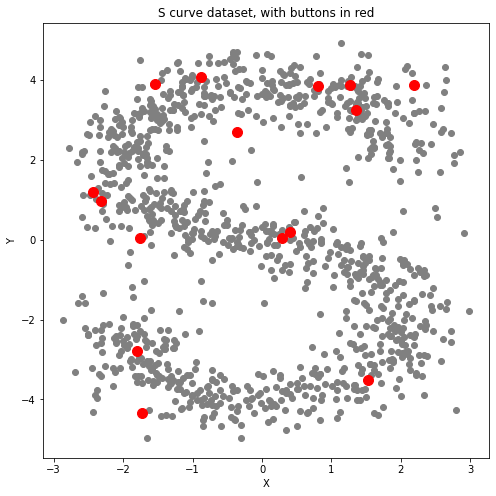

In [42]:
X= makeSCurve()
p=15
q=1
N=150
alpha_max=1
epsilon_max=3
buttons, grid, error= SOM(X, p, q, N, alpha_max, epsilon_max, compute_error=True, lambda_=0.01)
plotDataAndSOM(X, buttons, 'exercise1b.pdf')

#### 1c.

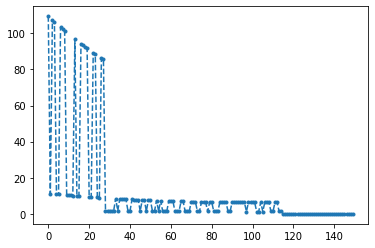

In [43]:
plt.plot(error, '.--')

### Exercise2:
#### 2a.

In [44]:
import pandas as pd

crabs = pd.read_csv('crabs.csv')
print(crabs.head(10))
data= crabs[['FL','RW', 'CL', 'CW', 'BD']]
data

  sp sex  index    FL    RW    CL    CW    BD
0  B   M      1   8.3   6.8  16.1  19.0   6.9
1  B   M      2   8.9   7.9  18.1  20.6   7.4
2  B   M      3   9.1   7.9  19.0  22.6   7.9
3  B   M      4   9.5   7.8  20.2  23.3   8.0
4  B   M      5  10.0   7.9  20.5  22.8   8.4
5  B   M      6  10.9   9.2  22.9  26.3   9.7
6  B   M      7  11.0  10.1  23.6  27.0   9.9
7  B   M      8  11.7   9.0  24.4  28.2  10.6
8  B   M      9  11.7   9.8  24.2  27.6   9.5
9  B   M     10  11.7  10.7  25.2  29.3  10.2


,FL,RW,CL,CW,BD
0,8.3,6.8,16.1,19.0,6.9
1,8.9,7.9,18.1,20.6,7.4
2,9.1,7.9,19.0,22.6,7.9
3,9.5,7.8,20.2,23.3,8.0
4,10.0,7.9,20.5,22.8,8.4
...,...,...,...,...,...
195,21.6,17.9,41.3,46.2,18.7
196,21.8,17.3,41.7,47.2,19.7
197,22.0,17.2,42.5,47.6,19.6
198,22.4,17.0,43.1,48.7,19.7


In [45]:
X= data.values
p=6
q=8
N=1000
alpha_max=1
epsilon_max=3

buttons, grid, error= SOM(X, p, q, N, alpha_max, epsilon_max, compute_error=False, lambda_=.002)

In [46]:
print('X shape',X.shape)
print('grid shape',grid.shape)
print('buttons shape',buttons.shape)


X shape (200, 5)
grid shape (48, 2)
buttons shape (48, 5)


In [53]:
def getLabels(buttons, X):
    N = X.shape[0]
    labels = np.zeros(N)
    for i in range(N):
        #find index of nearest button in feature space
        labels[i] = findNearestButtonIndex(X[i], buttons)
    return labels

In [54]:
crabs = "crabs.csv"
df = pd.read_csv(crabs)

#print(df)
#X = df.iloc[:, 3:8].as_matrix()  ####FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.

X = df.iloc[:, 3:8].values

idInfo = df.iloc[:, :2]
#print(X)
# print(idInfo)


#just to check it works with other p, q
p = 2
q = 2
p = 6
q = 8

N = 1000
alpha_max = 1
eps_max = 3
lam = 1e-3
np.random.seed(5)
buttons, grid, _ = SOM(X, p, q, N, lam, alpha_max, eps_max)

labels = getLabels(buttons, X)

In [56]:
import matplotlib.patches as mpatches
def plotSOMCrabs(grid, X, buttons):
    N = X.shape[0]
    proj = np.zeros(shape=(N,2))
    zeta = 0.05
    for i in range(N):
        #find index of nearest button in feature space
        label = findNearestButtonIndex(X[i], buttons)
        
        #label in grid space, with some noise to jitter
        proj[i,0] = grid[label, 0] + np.random.normal(0, zeta, 1)
        proj[i,1] = grid[label, 1] + np.random.normal(0, zeta, 1)
    
    
    #finally, plot the figure
    fig = plt.figure(figsize=(12, 12))
    #dark blue: #0038ff - Blue male
    #cyan:  #00eefd - Blue female
    #orange: #ffa22f - Orange male
    #yellow: #e9e824 - Orange female
    class_colours = np.array(['#0038ff', '#00eefd', '#ffa22f', '#e9e824'])
    classes = ['Blue male','Blue female','Orange male', 'Orange female']
    colors = class_colours.repeat(N/4)
#     plt.scatter(grid[:,0], grid[:,1], s=2000, facecolors='none')
    plt.scatter(proj[:,0], proj[:,1], s=50, c=colors)    
    plt.title('Self-organising map of crabs data', fontsize=16)

    #now make legend
    recs = []
    for i in range(0,len(class_colours)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
    plt.legend(recs,classes, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


2.b

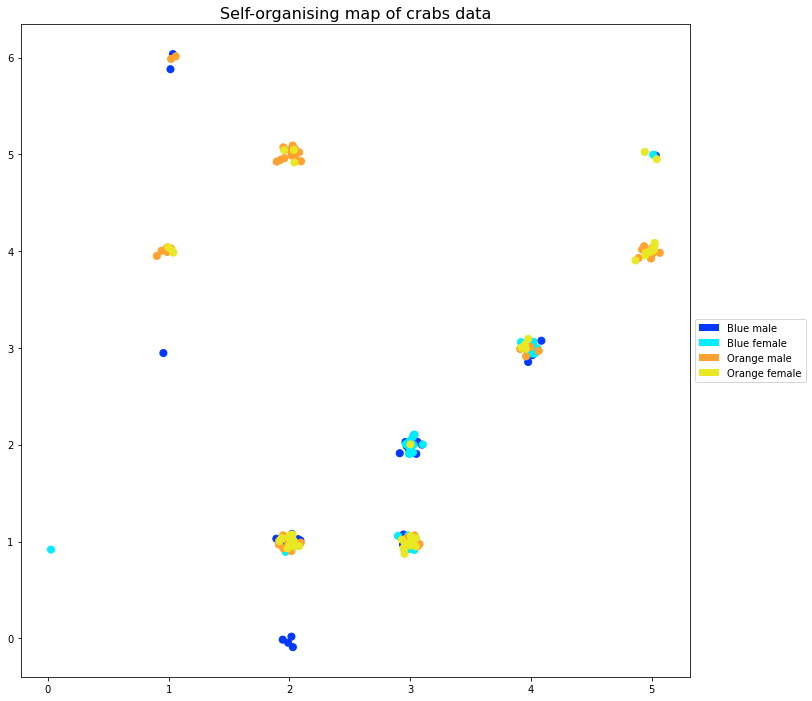

In [57]:
plotSOMCrabs(grid, X, buttons)